# Unsupervised outliers detection (event detection)

In [1]:
import sys 
sys.path.insert(0,'../')
import pymce2 as mce

import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA,TruncatedSVD,NMF,FastICA
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt
from matplotlib import gridspec
%matplotlib inline

## Defining clustering algorithm as clustering fucntion

In [2]:
agg = AgglomerativeClustering()

## Signal synthesis

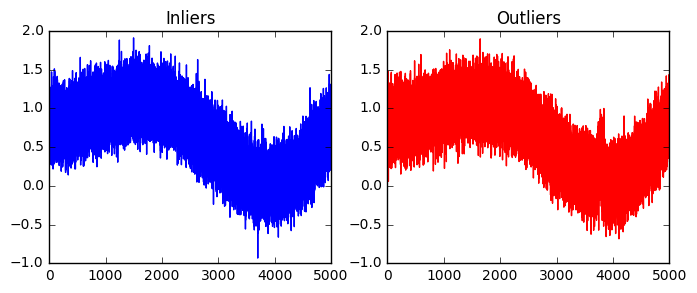

In [5]:
i_sig = 1
n_ftrs = 5000
noise = 0.2
# noise = 0.0
scl = 0.01
sft = 0.01

# x = np.tile(np.linspace(0,1,n_ftrs),2)

X, y = mce.synt_event(i_sig, n_ftrs,n_inlier=500,n_outlier=50,
                      sigma = noise,n1 = scl,n2 = sft,n3 = scl,n4 = sft,
                      mu=[0.75,0.76],amp=[0.2,0.3],sig=[0.005,0.01])

gs = gridspec.GridSpec(1, 2)
plt.figure(figsize=(8,3)) 
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.set_title('Inliers')
ax2.set_title('Outliers')

inliers = X[y==0]
outliers = X[y==1]
for i in range(10):
    ax1.plot(inliers[i],'b')
    ax2.plot(outliers[i],'r')
plt.savefig('Huge_data.jpg')

## Outlier detection using auto encoders

In [6]:
z_dim = 2
dim_rs ={'AE':'AE','VAE':'VAE','none':'none','PCA':PCA(n_components=z_dim),'NMF':NMF(n_components=2), 
         'FastICA':FastICA(n_components=2, max_iter=1000)}
dim_rs ={'FastICA':FastICA(n_components=2, max_iter=1000),'PCA':PCA(n_components=z_dim)}

metrics = ['correlation','mahalanobis','L2']
metrics = mce.metrics
for dim_r, value in dim_rs.iteritems():
    
    print '---------------  '+dim_r+'  ----------------'

    # Splitter definition
    splitter = mce.Splitter(X, reducer = value, 
                            network_architecture=[[n_ftrs,100,2],[2,100,n_ftrs]], 
                            clustering = agg.fit_predict, z_dim=z_dim)

    # Splitting
    splitter.split(1,verbose=0,training_epochs=20)
    
    # outlier extraction for all of requeste metrics
    outliers_r = mce.outliers(X,splitter,mce.metrics)
    outliers_l = mce.outliers_latent(splitter,metrics) 
    
    for metr in metrics:
        print '{:<12}: real:{:2.2f}, latent:{:2.2f}'.format(metr,roc_auc_score(y==1, outliers_r[metr]),
                                              roc_auc_score(y==1, outliers_l[metr]))

        
    # ensembling
#     ems_outliers = mce.norm_ensemble(outliers,0.1)
    
#     # AUC
#     auc = roc_auc_score(y==1, ems_outliers)

#     print '{}: AUC={:4.2f}'.format(dim_r,auc)

        
#     print '*********************************************'

---------------  PCA  ----------------
cityblock   : real:0.61, latent:0.94
L2          : real:0.66, latent:0.94
L4          : real:0.67, latent:0.94
braycurtis  : real:0.53, latent:0.95
canberra    : real:0.31, latent:0.95
chebyshev   : real:0.51, latent:0.94
correlation : real:0.81, latent:0.59
mahalanobis : real:0.57, latent:0.94
wL2         : real:0.65, latent:0.94
wL4         : real:0.65, latent:0.94
---------------  FastICA  ----------------
cityblock   : real:0.62, latent:0.95
L2          : real:0.65, latent:0.96
L4          : real:0.66, latent:0.97
braycurtis  : real:0.54, latent:0.96
canberra    : real:0.34, latent:0.96
chebyshev   : real:0.51, latent:0.97
correlation : real:0.79, latent:0.68
mahalanobis : real:0.29, latent:0.88
wL2         : real:0.64, latent:0.90
wL4         : real:0.63, latent:0.89


In [ ]:
models = {'r':'salam'}

for mth in models:
    print models[mth]

In [5]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering as AggC
from memory_profiler import memory_usage
from time import time

In [6]:
n_f = 200
n_d = 1000
x = np.concatenate((np.random.normal(0,0.5,(n_d,n_f)),np.random.normal(4,0.5,(n_d,n_f))),axis=0)
agg = AggC()

t0 = time()
mem_usage = memory_usage((agg.fit_predict, (x,)))
t1 = time()

print('Maximum memory usage: %s' % max(mem_usage))
print  t1-t0

Maximum memory usage: 270.4453125
0.848078012466


In [10]:
for i in splitter.z_mu:
    print mce.Cov_mat(i).shape

(3, 3)
(3, 3)
(3, 3)
(3, 3)


In [36]:
import pickle

def pklread(name):
    with open(name,'r') as f:
        data = pickle.load(f)
    return data

typ = 'event'
for i in range(1,11):
    d = pklread('../../code/corr_res/'+typ+'_cor'+str(i))
    cor1 = d[0]
    cor2 = d[1]
    names = d[2]

    fig = plt.figure(figsize=(18, 9))
    gs = gridspec.GridSpec(1,2)
    ax = fig.add_subplot(gs[0,0])
    ax.imshow(cor1,interpolation='none')
    ax.set_xticks(np.arange(50));
    ax.set_xticklabels(names, rotation='vertical');
    ax.set_yticks(np.arange(50));
    ax.set_yticklabels(names);
    ax.set_title('Correlation');

    ax = fig.add_subplot(gs[0,1])
    ax.imshow(cor2,interpolation='none')
    ax.set_xticks(np.arange(50));
    ax.set_xticklabels(names, rotation='vertical');
    ax.set_yticks(np.arange(50));
    ax.set_yticklabels(names);
    ax.set_title('Cohen-Kappa');

    ax.set_yticks(np.arange(50));
    ax.set_yticklabels(names);
    plt.subplots_adjust(wspace=0.23,bottom=0.17, top=0.97, left=0.09, right=0.99)
    plt.savefig('cm_'+typ+str(i)+'.jpg',dpi=200)
    plt.close()

In [9]:
ss = np.arange(4)

In [4]:
import pandas as pd
from sklearn import neighbors 
from sklearn.ensemble import IsolationForest
def sk_check(X_train,X_test,y_test,o_list):
    f_f = [neighbors.LocalOutlierFactor(n_neighbors=5),\
    neighbors.LocalOutlierFactor(n_neighbors=10),\
    neighbors.LocalOutlierFactor(n_neighbors=35),\
    IsolationForest(max_samples='auto')]
    f_name = ['LOF5','LOF10','LOF35','i-forest']

    columns = ['method']+['AUC','MCC','BRU']
    n_row = 2
    index = np.arange(n_row) # array of numbers for the number of samples
    df = pd.DataFrame(columns=columns, index = index)

    exec 'T_o ='+(' | '.join(['(y_test=='+str(i)+')' for i in o_list]))

    auc_max = -1
    for i in range(3):
        lof = f_f[i]
        lof.fit(X_test)
        outliers = -lof.negative_outlier_factor_

        auc_test = roc_auc_score(T_o, outliers)
        if auc_test>auc_max:
            auc_max = auc_test
            df['method'][0] = f_name[i]
            df['MCC'][0] = mce.MCC(T_o, outliers)
            df['AUC'][0] = auc_max
            df['BRU'][0] = mce.bru_score(T_o, outliers)

    df['method'][1] = f_name[3]
    isof = f_f[3]
    isof.fit(X_train)
    scores_pred = isof.decision_function(X_test)
    outliers = scores_pred.max()-scores_pred
    df['MCC'][1] = mce.MCC(T_o, outliers)
    df['AUC'][1] = roc_auc_score(T_o, outliers)
    df['BRU'][1] = mce.bru_score(T_o, outliers)

    return df

In [5]:
sk_check(X,X,y,[1])

,method,AUC,MCC,BRU
0,LOF35,0.659,0.098,0.170196
1,i-forest,0.5974,0.098,0.0823529
